# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import janitor
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import PercentFormatter
px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from mlxtend.plotting import plot_decision_regions
from sklearn import __version__ as sklearn_version
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
                              GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor,
                              VotingClassifier)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, average_precision_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler, MinMaxScaler, Normalizer,
                                   StandardScaler, normalize, scale)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [5]:
import joblib
import requests
from dotenv import load_dotenv
load_dotenv()
APIKEY = os.getenv("SOME_KEY")
%reload_ext watermark
%watermark -a 'Ken Cavagnolo' -n -u -v -m -h -g -p jupyter,notebook,pandas,numpy,scipy

Author: Ken Cavagnolo

Last updated: Thu Sep 30 2021

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.25.0

jupyter : 1.0.0
notebook: 6.4.0
pandas  : 1.3.0
numpy   : 1.19.5
scipy   : 1.7.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.13.0-7614-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Hostname: goldfinch

Git hash: 56e394cc4e7c99906bce093665acbadca18265e6



# GPU Check

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import torch
from tensorflow.python.client import device_lib

hello = tf.constant("Hello, TensorFlow!")
with tf.device("/gpu:0"):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name="a")
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name="b")
    c = tf.matmul(a, b)
print("-" * 20)
print("<<< Testing Tensorflow >>>")
print("<<< Version: ", tf.__version__)
print("<<< Eager mode: ", tf.executing_eagerly())
print("<<< Hub version: ", hub.__version__)
print(
    "<<< GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE",
)
print("<<< Code check...")
tf.print(hello)
tf.print(c)
print("-" * 20)

# torch
print("-" * 20)
print("<<< Testing Torch >>>")
print(f"<<< Version: {torch.__version__}")
print(
    "<<< GPU is",
    "available"
    if any("GPU" in d.name for d in device_lib.list_local_devices())
    else "NOT AVAILABLE",
)
print("<<< CUDA is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")
print("<<< Code check...")
x = torch.rand(5, 3)
print(x)
print("-" * 20)


# Functions

In [6]:
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.

        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError(
            'multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError(
            'Some classes do not have enough examples. Change min_count if necessary.'
        )

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(
        seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices,
                                        size=min_count,
                                        replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])

In [7]:
def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]

In [8]:
def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y,
                                      size=size,
                                      min_count=min_count,
                                      seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask],
            Y[test_set_mask])

In [9]:
def score_submission(pred_path=None,
                     holdout_path=None):
    # this happens on the backend to get the score
    holdout_labels = pd.get_dummies(
        pd.read_csv(holdout_path,
                    index_col=0).apply(lambda x: x.astype('category'), axis=0))

    preds = pd.read_csv(pred_path, index_col=0)

    # make sure that format is correct
    assert (preds.columns == holdout_labels.columns).all()
    assert (preds.index == holdout_labels.index).all()

    return _multi_multi_log_loss(preds.values, holdout_labels.values)

# Load Data

In [114]:
# load data and use pyjanitor to clean
train_df = pd.read_csv("datasets/train.csv", index_col=0)
test_df = pd.read_csv("datasets/test.csv", index_col=0)
holdout_df = pd.read_csv("datasets/holdout.csv", index_col=0)

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [115]:
train_df.sample(5)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
57239,Instructional Materials & Supplies,Instruction,School Reported,School,NO_LABEL,NO_LABEL,Supplies/Materials,NO_LABEL,PreK-12 Operating,SUPPLIES,...,NaN,NaN,NaN,INSTRUCTION,NaN,NaN,315.410000,SPECIAL EDUCATION CATEGORY III,General Fund,NaN
243442,Extended Time & Tutoring,Instruction,School Reported,School,At Risk,Teacher,Other Compensation/Stipend,Non PreK,PreK-12 Operating,Salaries And Wages For Teachers And Other Prof...,...,Extended Day,School,NaN,Instruction,Instruction And Curriculum,TEACHER BACHELOR,77.953218,"""Title I, Part A Schoolwide Activities Related...",General Operating Fund,EXTENDED DAYS
283316,Food Services,O&M,School Reported,School,Unspecified,Non-Position,Supplies/Materials,NO_LABEL,PreK-12 Operating,SMALL KITCHEN SUPPLIES,...,NaN,NaN,NaN,NON-PROJECT,NaN,UNDESIGNATED,2435.790000,FOOD PREPARATION/SERVING,NaN,FOOD SERVICES OPERATIONS
445474,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,RETIREMENT CONTRIB.,...,NaN,NaN,NaN,EMPLOYEE RETIREMENT,NaN,UNDESIGNATED,46.460000,EMPLOYEE BENEFITS,NaN,EMPLOYEE BENEFITS
48780,Curriculum Development,NO_LABEL,Leadership & Management,Non-School,NO_LABEL,NO_LABEL,Supplies/Materials,NO_LABEL,PreK-12 Operating,SUPPLIES,...,NaN,ADMIN. SERVICES,NaN,INSTRUCTION,NaN,NaN,-619.750000,Misc,General Fund,NaN


In [57]:
# inspect
#profile_report = train_df.profile_report(sort=None,
#                                         explorative=True,
#                                         html={"style": {
#                                             "full_width": True
#                                         }},
#                                         progress_bar=True)
#profile_report.to_file("docs/train_profile.html")

# EDA

## Categorical Features

In [116]:
# look for possible categorical columns
MIN_CATEGORIES = 2
MAX_CATEGORIES = 40
categorical_cols = []
print("Possibly categorical columns...")   
for col in train_df.select_dtypes(include=["object"]).columns:
    if MIN_CATEGORIES < len(train_df[col].value_counts()) < MAX_CATEGORIES:
        categorical_cols.append(col)
        print(f"  {col}")
if len(categorical_cols) == 0:
    print("   None")

Possibly categorical columns...
  Function
  Use
  Sharing
  Reporting
  Student_Type
  Position_Type
  Object_Type
  Pre_K
  Operating_Status
  Text_3


In [117]:
# change the column type
categorical_cols.remove("Text_3")
categorize_feature = lambda x: x.astype("category")
train_df[categorical_cols].apply(categorize_feature, axis=0)
train_df.sample(5)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
14366,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF PART TIME EMPLOYEE,...,NaN,NaN,0.00431,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,109.477938,INSTRUCTIONAL STAFF TRAINING,NaN,INSTRUCTIONAL STAFF
96306,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Telephone Service,...,Communications *,NaN,NaN,State and Federal Projects Coordination Services*,NaN,NaN,-283.110000,NaN,Title I - Disadvantaged Children/Targeted Assi...,ESEA TITLE I
379878,School Administration,Leadership,School Reported,School,Unspecified,Principal,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Principals,...,NaN,NaN,1.00000,NaN,NaN,PRINCIPAL,83940.560000,Principal's Office,General Purpose School,NaN
76402,Student Transportation,O&M,Shared Services,Non-School,Special Education,Other,Other Compensation/Stipend,NO_LABEL,PreK-12 Operating,PART-TIME EXTRA PAY,...,NaN,GARAGE,NaN,NON-PROJECT,NaN,"CRAFTS, TRADES, AND SERVICES",81.742160,TRANSPORTATION-OPERATIONS,NaN,STUDENT TRANSPORTATION
34166,Social & Emotional,Pupil Services & Enrichment,School Reported,School,Unspecified,Guidance Counselor,Base Salary/Compensation,Non PreK,PreK-12 Operating,Salaries And Wages For Teachers And Other Prof...,...,Salaries And Wages For Teachers And Other Prof...,School,0.35000,"""Guidance, Counseling And Evaluation Services""",All Campus Payroll,COUNSELOR MIDDLE SCHOOL,30372.944250,Undistributed,General Operating Fund,REGULAR PAY


Text(0, 0.5, 'Number of unique values')

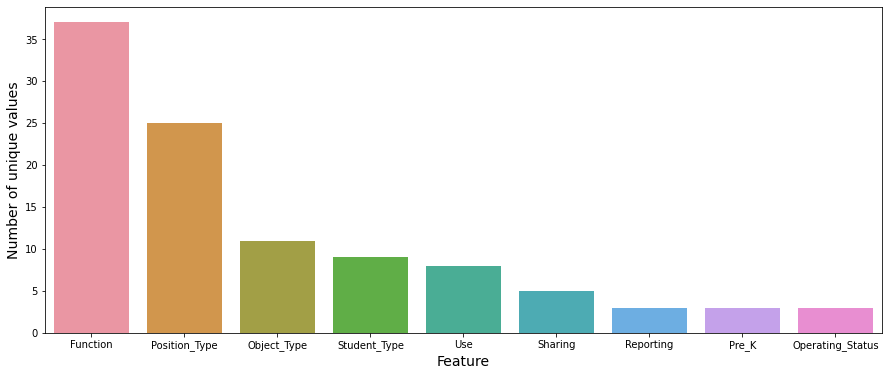

In [118]:
# display unique values for each feature
n_unique_features = train_df[categorical_cols].apply(pd.Series.nunique).sort_values(ascending=False)
sns.barplot(x=n_unique_features.index, y=n_unique_features.values)
plt.xlabel('Feature')
plt.ylabel('Number of unique values')

In [119]:
categorical_dummies = pd.get_dummies(train_df[categorical_cols])
categorical_dummies.sample(5)

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
280100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
88547,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
360738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
44579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
218956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


## Numerical Features

In [120]:
# look for possible numeric columns
numeric_cols = train_df.select_dtypes(include=["number"]).columns.to_list()
print("Numeric columns...")
for c in numeric_cols:
    print(f"  {c}")

Numeric columns...
  FTE
  Total


In [121]:
numeric_data = train_df[numeric_cols].fillna(-1000)

## Text Features

In [122]:
non_text_cols = numeric_cols + categorical_cols
text_cols = [c for c in train_df.columns if c not in non_text_cols]

In [123]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Join all text items in a row that have a space in between
text_vector = train_df[text_cols].fillna("").apply(lambda x: " ".join(x), axis=1)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 4757 tokens in the dataset
There are 3284 alpha-numeric tokens in the dataset


# Preprocessing

In [64]:
# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(
    numeric_data, categorical_dummies, size=0.2, seed=42)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")
print(X_test.info())
print("\ny_train info:")
print(y_train.info())
print("\ny_test info:")
print(y_test.info())

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 206341 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     320222 non-null  float64
 1   Total   320222 non-null  float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 134338 to 433672
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     80055 non-null  float64
 1   Total   80055 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 206341 to 415831
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 134338 to 433672
Columns: 104 entries, Fun

# Modeling

In [65]:
# model name
model_name = "models/ovr_logreg.joblib"

In [ ]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

# save model
joblib.dump(clf, model_name) 

In [66]:
# reload model
clf = joblib.load(model_name) 

# Generate predictions: predictions
predictions = clf.predict_proba(test_df[numeric_cols].fillna(-1000))

# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(train_df[categorical_cols]).columns,
                             index=test_df.index,
                             data=predictions)


# Save prediction_df to csv
prediction_df.to_csv("datasets/predictions.csv")

<div class="alert alert-block alert-danger">
<b>WARNING</b></div>

Sorry, this exercise ends here because the peeps at Datacamp ensured that their tutorial is not fully reproducible by using a `score_submission` function that relies on a hidden file they do not share.

<div class="alert alert-block alert-danger">
<b>:(</b></div>